<a href="https://colab.research.google.com/github/qwertyqwertyqwertyqwerty123/colab_projects/blob/main/mi_xi2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Хи^2 + взаимная информация

Mounted at /content/drive
Загружено 298 строк, 6 признаков


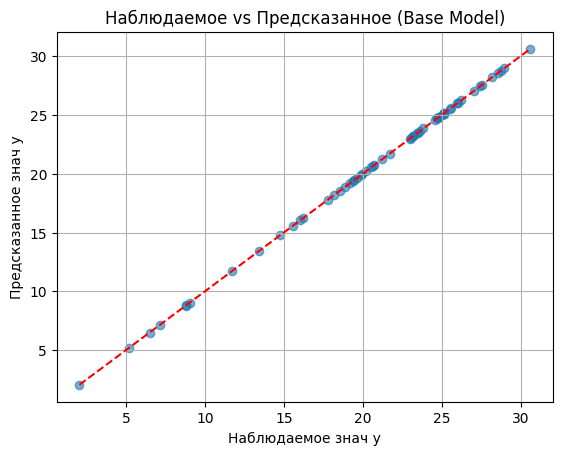


Сравнение моделей по отбору признаков:
                 Model       MAE        R² Selected Features
0  Base (All Features)  0.005264  0.999998               All
1          Mutual Info  1.506842  0.904360         [1, 2, 3]
2         F-Regression  2.509241  0.760226         [3, 5, 1]


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.preprocessing import MinMaxScaler
from google.colab import drive

# Загрузка данных
def load_data(filename):
    drive.mount('/content/drive')
    dir_path = "/content/drive/My Drive/"
    try:
        data = pd.read_csv(dir_path + filename, delimiter=r'\s+', engine='python', header=None)
        X = data.iloc[:, :-1].apply(pd.to_numeric, errors='coerce')
        y = data.iloc[:, -1].apply(pd.to_numeric, errors='coerce')
        valid_rows = ~X.isna().any(axis=1) & ~y.isna() #выделение некорректных строк
        X = X[valid_rows].astype(float)
        y = y[valid_rows].astype(float)
        return X, y
    except Exception as e:
        print(f"Ошибка при загрузке файла: {e}")
        return None, None

# Оценка модели
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return mean_absolute_error(y_test, y_pred), r2_score(y_test, y_pred)

# Основная логика
def main(filename):
    X, y = load_data(filename)
    if X is None or y is None:
        return

    print(f"Загружено {X.shape[0]} строк, {X.shape[1]} признаков")

    # Разделение данных
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Лин регрессия на всех признаках
    base_model = LinearRegression()
    base_mae, base_r2 = evaluate_model(base_model, X_train, X_test, y_train, y_test)

    # Масштабирование для mutual_info и chi2 (f_regression)
    scaler = MinMaxScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
    X_train_scaled, X_test_scaled = train_test_split(X_scaled, test_size=0.2, random_state=42)

    # Метод 1: Взаимная информация
    mi_selector = SelectKBest(score_func=mutual_info_regression, k=3)
    mi_selector.fit(X_train_scaled, y_train)
    top_mi_features = np.argsort(mi_selector.scores_)[-3:]

    # ----- Метод 2: Хи-квадрат → f_regression -----
    f_selector = SelectKBest(score_func=f_regression, k=3)
    f_selector.fit(X_train_scaled, y_train)
    top_f_features = np.argsort(f_selector.scores_)[-3:]

    # Обучение моделей
    model_mi = LinearRegression()
    model_f = LinearRegression()

    # Подмножества признаков
    X_train_mi = X_train_scaled.iloc[:, top_mi_features]
    X_test_mi = X_test_scaled.iloc[:, top_mi_features]

    X_train_f = X_train_scaled.iloc[:, top_f_features]
    X_test_f = X_test_scaled.iloc[:, top_f_features]

    # Оценка моделей
    mae_mi, r2_mi = evaluate_model(model_mi, X_train_mi, X_test_mi, y_train, y_test)
    mae_f, r2_f = evaluate_model(model_f, X_train_f, X_test_f, y_train, y_test)

    # Таблица результатов
    results = pd.DataFrame({
        'Model': ['Base (All Features)', 'Mutual Info', 'F-Regression'],
        'MAE': [base_mae, mae_mi, mae_f],
        'R²': [base_r2, r2_mi, r2_f],
        'Selected Features': ['All', list(top_mi_features), list(top_f_features)]
    })

    # Визуализация результатов базовой модели
    import matplotlib.pyplot as plt

    base_model.fit(X_train, y_train)
    y_pred = base_model.predict(X_test)

    plt.scatter(y_test, y_pred, alpha=0.6)
    plt.xlabel('Наблюдаемое знач y')
    plt.ylabel('Предсказанное знач y')
    plt.title('Наблюдаемое vs Предсказанное (Base Model)')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # линия идеальных предсказаний
    plt.grid(True)
    plt.show()

    print("\nСравнение моделей по отбору признаков:")
    print(results)

# Запуск
main('data.prn')

При использовании всех признаков в линейной регрессии коэф детерминации = 0,99, а MAE  - 0,005